## RNN for Stock Prediction
### Thomas Billington

In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

### Stock Preperation and Visualization

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<Figure size 1080x504 with 0 Axes>

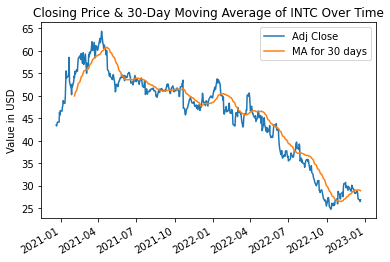

<Figure size 1080x504 with 0 Axes>

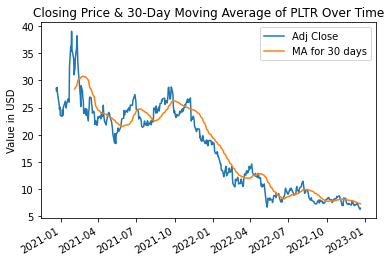

<Figure size 1080x504 with 0 Axes>

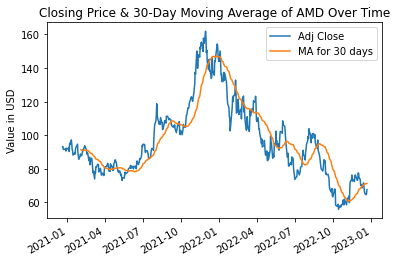

<Figure size 1080x504 with 0 Axes>

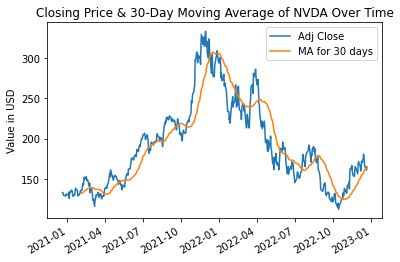

<Figure size 1080x504 with 0 Axes>

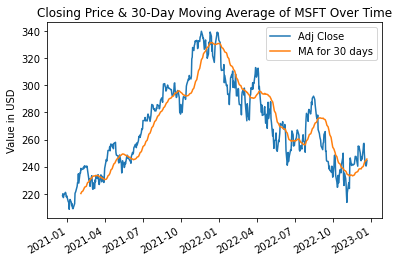

In [23]:
companylist = ['INTC', 'PLTR', 'AMD', 'NVDA', "MSFT"]
companynames = ['INTC', 'PLTR', 'AMD', 'NVDA', "MSFT"]

#sets an end date of todays date along with a start date of 2 years prior
enddate = datetime.now()
startdate = datetime(enddate.year - 2, enddate.month, enddate.day)

#goes through each company in the list and loads the data accordingly
counter = 0
for stock in companylist:
    companylist[counter] = yf.download(stock, startdate, enddate)
    counter += 1

#creates a dataframe with the company name and the listing data
for company, companyname in zip(companylist, companynames):
    company["Listing"] = companyname

df = pd.concat(companylist, axis=0)

#df.tail(10)
#companylist[3].describe()

#visualizing the closing price as well as the 30 day moving average of each listing
for company in companylist:
        column_name = f"MA for 30 days"
        company[column_name] = company['Adj Close'].rolling(30).mean()

counter2 = 0
for i, company in enumerate(companylist, 1):
    plt.figure(figsize=(15, 7))
    company[['Adj Close', 'MA for 30 days']].plot()
    plt.ylabel('Value in USD')
    plt.xlabel(None)
    plt.title(f"Closing Price & 30-Day Moving Average of {companynames[counter2]} Over Time")
    counter2 += 1

### Data Formatting

In [75]:
data = yf.download('NVDA', startdate, enddate)
df_stock = data.filter(['Close'])
df_stock = df_stock.values
df_stock

scaler = MinMaxScaler()
df_stock_reshape = df_stock.reshape(df_stock.shape[0], 1)
df_scaled_reshape = scaler.fit_transform(df_stock_reshape)
df_scaled_reshape

training_data = df_scaled_reshape[0:int(np.ceil( len(df_stock) * .95 )), :]

X_train, y_train = [], []

#30-Day periods
for i in range(30, len(training_data)):
    X_train.append(training_data[i-30:i, 0])
    y_train.append(training_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

[*********************100%***********************]  1 of 1 completed


(450, 30, 1)

### Model Setup